In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import sys
sys.path.insert(0,"../src/")
#sys.path.insert(0,"../src_fork/analysis")

import linear_regression
import utils
import stat_tools
import crossvalidation
import bootstrap
from FrankeFunction import FrankeFunction


utils.plot_settings()  # LaTeX fonts in Plots!

FIGPATH = "../figs/"
FIGURESIZE= np.array([4,3]) # Good default figure size for tex documents

SEEDVAL = 2021

In [2]:
np.random.seed(SEEDVAL)
n = 500
noise_scale = 0.2
x = np.random.uniform(0, 1, n)
y = np.random.uniform(0, 1, n)
z = FrankeFunction(x, y)
# Adding standard normal noise:
z = z + noise_scale * np.random.normal(0, 1, len(z))
max_degree = 15
n_lambdas = 30
n_bootstraps = 100
k_folds = 5
lambdas = np.logspace(-5, 0, n_lambdas)
subset_lambdas = lambdas[::60]

x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x, y, z, test_size=0.2)

#   Centering the response
z_intercept = np.mean(z)
z = z - z_intercept

#   Centering the response
z_train_intercept = np.mean(z_train)
z_train = z_train - z_train_intercept
z_test = z_test - z_train_intercept

########### Setup of problem is completed above.

# Quantities of interest: note the indexing, element 0 is polynomial degree 1
mse_ols_test = np.zeros(max_degree)
mse_ols_train = np.zeros(max_degree)
ols_cv_mse = np.zeros(max_degree)

ols_boot_mse = np.zeros(max_degree)
ols_boot_bias = np.zeros(max_degree)
ols_boot_variance = np.zeros(max_degree)

best_ridge_lambda = np.zeros(max_degree)
best_ridge_mse = np.zeros(max_degree)
ridge_best_lambda_boot_mse = np.zeros(max_degree)
ridge_best_lambda_boot_bias = np.zeros(max_degree)
ridge_best_lambda_boot_variance = np.zeros(max_degree)

best_lasso_lambda = np.zeros(max_degree)
best_lasso_mse = np.zeros(max_degree)
lasso_best_lambda_boot_mse = np.zeros(max_degree)
lasso_best_lambda_boot_bias = np.zeros(max_degree)
lasso_best_lambda_boot_variance = np.zeros(max_degree)

ridge_lamb_deg_mse = np.zeros((max_degree, n_lambdas))
lasso_lamb_deg_mse = np.zeros((max_degree, n_lambdas))

ridge_subset_lambda_boot_mse = np.zeros((max_degree, len(subset_lambdas)))
ridge_subset_lambda_boot_bias = np.zeros((max_degree, len(subset_lambdas)))
ridge_subset_lambda_boot_variance = np.zeros((max_degree, len(subset_lambdas)))
lasso_subset_lambda_boot_mse = np.zeros((max_degree, len(subset_lambdas)))
lasso_subset_lambda_boot_bias = np.zeros((max_degree, len(subset_lambdas)))
lasso_subset_lambda_boot_variance = np.zeros((max_degree, len(subset_lambdas)))

# Actual computations
for degree_index in range(max_degree):
    degree = degree_index + 1 # Little sense in doing stuff for 0 degrees.
    X = linear_regression.design_matrix_2D(x, y, degree)
    X_train = linear_regression.design_matrix_2D(x_train, y_train, degree)
    X_test = linear_regression.design_matrix_2D(x_test, y_test, degree)
    # Scaling and feeding to CV.
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    X_scaled = X_scaled[:,1:]
    #    X_scaled[:,0] = 1 # Maybe not for ridge+lasso. Don't want to penalize constants...

    # Scaling and feeding to bootstrap and OLS
    scaler_boot = StandardScaler()
    scaler_boot.fit(X_train)
    X_train_scaled = scaler_boot.transform(X_train)
    X_test_scaled = scaler_boot.transform(X_test)
    X_train_scaled = X_train_scaled[:,1:]
    X_test_scaled = X_test_scaled[:,1:]
    #    X_train_scaled[:,0] = 1 #maybe not for ridge+lasso
    #    X_test_scaled[:,0] = 1 #maybe not for ridge+lasso

    # OLS, get MSE for test and train set.

    betas = linear_regression.OLS_SVD_2D(X_train_scaled, z_train)
    z_test_model = X_test_scaled @ betas
    z_train_model = X_train_scaled @ betas
    mse_ols_train[degree_index] = stat_tools.MSE(z_train, z_train_model)
    mse_ols_test[degree_index] = stat_tools.MSE(z_test, z_test_model)

    # CV, find best lambdas and get mse vs lambda for given degree. Also, gets
    # ols_CV_MSE

    lasso_cv_mse, ridge_cv_mse, ols_cv_mse_deg = crossvalidation.k_fold_cv_all(
        X_scaled, z, n_lambdas, lambdas, k_folds
    )
    best_lasso_lambda[degree_index] = lambdas[np.argmin(lasso_cv_mse)]
    best_ridge_lambda[degree_index] = lambdas[np.argmin(ridge_cv_mse)]
    best_lasso_mse[degree_index] = np.min(lasso_cv_mse)
    best_ridge_mse[degree_index] = np.min(ridge_cv_mse)
    lasso_lamb_deg_mse[degree_index] = lasso_cv_mse
    ridge_lamb_deg_mse[degree_index] = ridge_cv_mse
    ols_cv_mse[degree_index] = ols_cv_mse_deg

    # All regression bootstraps at once
    lamb_ridge = best_ridge_lambda[degree_index]
    lamb_lasso = best_lasso_lambda[degree_index]

    (
        ridge_mse,
        ridge_bias,
        ridge_variance,
        lasso_mse,
        lasso_bias,
        lasso_variance,
        ols_mse,
        ols_bias,
        ols_variance,
    ) = bootstrap.bootstrap_all(
        X_train_scaled, X_test_scaled, z_train, z_test, n_bootstraps, lamb_lasso, lamb_ridge
    )

    (
        ridge_best_lambda_boot_mse[degree_index],
        ridge_best_lambda_boot_bias[degree_index],
        ridge_best_lambda_boot_variance[degree_index],
    ) = (ridge_mse, ridge_bias, ridge_variance)

    (
        lasso_best_lambda_boot_mse[degree_index],
        lasso_best_lambda_boot_bias[degree_index],
        lasso_best_lambda_boot_variance[degree_index],
    ) = (lasso_mse, lasso_bias, lasso_variance)

    ols_boot_mse[degree_index], ols_boot_bias[degree_index], ols_boot_variance[degree_index] = (
        ols_mse,
        ols_bias,
        ols_variance,
    )

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.001839706192941, tolerance: 0.004455444394051063
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.277666391286582, tolerance: 0.004567172690415966
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.876812986004834, tolerance: 0.004216854012732998
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.60296756607694, tolerance: 0.0043567057993242975
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.546227713759766, tolerance: 0.004431192749463325
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.335116982350407, tolerance: 0.004654584538725579
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.299767149501822, tolerance: 0.004184285884239671
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.125471365945055, tolerance: 0.004298862813202468
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.372660395028564, tolerance: 0.004759954881863609
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2163917868666818, tolerance: 0.004238039007135161
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2653184631834389, tolerance: 0.004452628722306348
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.45806830921965513, tolerance: 0.00437457813598719
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordina

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.060659023090484, tolerance: 0.004175185081355831
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.680867221485666, tolerance: 0.0045771676305330685
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.775149065859809, tolerance: 0.004274324826533679
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.155102695098899, tolerance: 0.004456245471992062
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.541284026943761, tolerance: 0.0036050540112120572
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.156850201045856, tolerance: 0.004338611435750001
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2459860551591415, tolerance: 0.004706349772806014
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.334307222559125, tolerance: 0.004285497807554294
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.091264765168028, tolerance: 0.004490852403047863
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.62271833642619, tolerance: 0.005759300651711913
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.843056759786606, tolerance: 0.00498109365200543
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.283420171986643, tolerance: 0.004669080798565293
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_de

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.821358463300806, tolerance: 0.004472959057695963
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.106719033936894, tolerance: 0.004746709709686472
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.123568976823357, tolerance: 0.004889197881077501
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.08064933032801, tolerance: 0.004409853512719925
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.443664000299085, tolerance: 0.004147900615025486
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.783863881922635, tolerance: 0.004663520507383054
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_d

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.145324316867205, tolerance: 0.004663520507383054
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.4475569007722875, tolerance: 0.0043244680378757595
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.173648560897695, tolerance: 0.004368297427944711
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinat

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.099233314246913, tolerance: 0.004780305639793241
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.187781542977326, tolerance: 0.004540259197317553
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.322454536615439, tolerance: 0.0047021078160019505
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.45304339138784, tolerance: 0.004587246941414342
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.350245403071433, tolerance: 0.003776393492279069
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.194792368290576, tolerance: 0.0044010811252846735
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.642726301159069, tolerance: 0.0039586132070380175
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.99537685884615, tolerance: 0.004148979090996448
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.942193162225168, tolerance: 0.004086947661302474
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.138228159578079, tolerance: 0.0044389111318597525
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.5635362815759954, tolerance: 0.004233529565860948
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.5605240443295845, tolerance: 0.004469003336776177
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordina

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.825719758049747, tolerance: 0.0044389111318597525
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.34348068544635, tolerance: 0.004233529565860948
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3591861454174143, tolerance: 0.004469003336776177
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.816738634622094, tolerance: 0.0051719197340102645
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.836584677453228, tolerance: 0.004694739668749689
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.386445924577146, tolerance: 0.005016774517550765
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.457899539542908, tolerance: 0.003483753111631836
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.420302193661709, tolerance: 0.00465943558916177
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.464735899933128, tolerance: 0.004566559330654927
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_d

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.666171039493079, tolerance: 0.004941833016106985
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.972032118306579, tolerance: 0.0045604272766744175
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.5047395551052, tolerance: 0.0045435641500762335
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.700951574902263, tolerance: 0.00438052368425329
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.720068233416864, tolerance: 0.004382072721567381
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.302078723104834, tolerance: 0.004712482079975432
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_d

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.418331240999006, tolerance: 0.004447015447962552
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.444751480752098, tolerance: 0.00453324553712878
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.21373186752821, tolerance: 0.004729187493492685
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_de

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.048531461499303, tolerance: 0.004434250546076389
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.211765635533806, tolerance: 0.004359397036315412
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.779134120956558, tolerance: 0.004822268647056769
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.609164715827524, tolerance: 0.004785256088637939
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.367578913761201, tolerance: 0.004880604654275369
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.163290317397752, tolerance: 0.00464967059622384
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_d

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.181968782881064, tolerance: 0.004291187327180606
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.187646032679128, tolerance: 0.004323155833997568
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.30480537139584, tolerance: 0.004624227688844155
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_d

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.149087564221888, tolerance: 0.004291187327180606
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.908511455840748, tolerance: 0.004323155833997568
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2917728392716787, tolerance: 0.004624227688844155
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.342672280510312, tolerance: 0.004408085944071704
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.7539623310776005, tolerance: 0.004404844773032255
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6617112553019053, tolerance: 0.0037812655318333784
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordina

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.569199435924512, tolerance: 0.0038958174288846567
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.118587229825822, tolerance: 0.004712356603044343
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.7765910940162675, tolerance: 0.004190398974916685
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinat

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.424885979747362, tolerance: 0.004751973580903546
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.7363281674968825, tolerance: 0.004805625500494675
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.450029564328272, tolerance: 0.004585252798486609
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.30483722622398, tolerance: 0.004348049516861942
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.880615359514467, tolerance: 0.004460894002067267
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.045063625224451, tolerance: 0.0043688042967637165
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3367181692755654, tolerance: 0.004449044543171436
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20271895788214422, tolerance: 0.004287247742084573
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.25280918996822344, tolerance: 0.004348049516861942
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordi

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.59753663324284, tolerance: 0.005154745475412882
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7078343596851955, tolerance: 0.003744014556988441
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.814164560388969, tolerance: 0.004710878061428231
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.913618370525036, tolerance: 0.00432445835427098
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.285022824940054, tolerance: 0.004385438736297516
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.5106703750480435, tolerance: 0.004722007889714696
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.8483899814961795, tolerance: 0.004996544199048555
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.539864480166906, tolerance: 0.0051680969073378555
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.257750093394055, tolerance: 0.004510594499212936
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinat

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.5329602605868775, tolerance: 0.004606772294032286
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.089420595474105, tolerance: 0.004468168058504401
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.700521053384316, tolerance: 0.004280472632703331
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2958667037222593, tolerance: 0.004407476809842174
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.22452945804367985, tolerance: 0.004606772294032286
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1725518302993887, tolerance: 0.004468168058504401
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordin

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.409059230007786, tolerance: 0.004317406942729702
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.647797684942319, tolerance: 0.004419178075862132
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.111904853033505, tolerance: 0.004526331144060505
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.8252124711977995, tolerance: 0.004266043867657952
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.086624273151116, tolerance: 0.004549176327373097
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.002666951590588, tolerance: 0.004695668198671688
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.6190808035122295, tolerance: 0.00406159615067199
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.186981137767184, tolerance: 0.004069688185231072
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.153877360473129, tolerance: 0.00467113021120862
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_d

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.410453147700536, tolerance: 0.004451521638249486
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.40844140508793, tolerance: 0.004386948484267541
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.5707986521211765, tolerance: 0.004343246986820627
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12155084405346628, tolerance: 0.004452548364229906
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.25928887463219397, tolerance: 0.0042797746273813735
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1274631863944542, tolerance: 0.004451521638249486
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.191802881435156, tolerance: 0.004391734385262454
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.92374773822679, tolerance: 0.0038242339273980583
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.464022635696307, tolerance: 0.004262874618182845
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.696836592460009, tolerance: 0.004623045650587747
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.958464591508736, tolerance: 0.004340247162005362
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.691594253503075, tolerance: 0.004231923180736772
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.660129386841441, tolerance: 0.004414891133243336
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.799358477746304, tolerance: 0.004554289379483132
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.038595632370131, tolerance: 0.005029696897774426
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.968627325991469, tolerance: 0.004419832636250442
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.179558126979499, tolerance: 0.00440215834762623
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.187558811370002, tolerance: 0.004198303913396562
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_d

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.739142127900459, tolerance: 0.00440215834762623
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.927267047360636, tolerance: 0.004198303913396562
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.213430238103593, tolerance: 0.004544043831600545
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_d

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006074848607447336, tolerance: 0.0043497013720751555
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009999689665313838, tolerance: 0.00440215834762623
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.440557888220374, tolerance: 0.00476586839274562
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordi

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.821112165733045, tolerance: 0.004452823881483476
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.86479419415155, tolerance: 0.004152303020082367
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.27213116235937, tolerance: 0.004671650317707231
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_de

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.627257098636149, tolerance: 0.004514777552149343
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.418160771646884, tolerance: 0.004446382852330115
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.166135721197096, tolerance: 0.004569462569816587
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.075269042090266, tolerance: 0.004506980571241115
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.960947185098494, tolerance: 0.0043805489170401215
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.865739623545073, tolerance: 0.004271608247616578
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.790969265467667, tolerance: 0.004362578602535833
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.8343623518191805, tolerance: 0.004392323762515286
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.85174526567714, tolerance: 0.004506980571241115
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019104401294189444, tolerance: 0.004362578602535833
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014500334128552339, tolerance: 0.004392323762515286
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014270337221581997, tolerance: 0.0043805489170401215
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_c

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.131579754295643, tolerance: 0.004499350401286717
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.138085880002784, tolerance: 0.003914305732624967
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.3644822123117155, tolerance: 0.004693026673916918
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.822874083081798, tolerance: 0.004787543213199079
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.263629804179413, tolerance: 0.004389134553446337
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.922231187556779, tolerance: 0.004373400899522104
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.685086838527564, tolerance: 0.005049949878875392
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.460283393276336, tolerance: 0.0051279985146603195
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.210621488745544, tolerance: 0.005133457641476693
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.280034594938289, tolerance: 0.0043735944357049476
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.425568006640276, tolerance: 0.0044473572344722115
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.525633556539607, tolerance: 0.004132135885726696
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinat

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5820570889655627, tolerance: 0.004132135885726696
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4623111238959954, tolerance: 0.004412654034812251
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.446019797664591, tolerance: 0.004548298510232828
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinat

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.081067351573312, tolerance: 0.004241877852373609
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.751852087855438, tolerance: 0.004703766259227813
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6649323594886623, tolerance: 0.004470655529994572
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8972264864951853, tolerance: 0.004314377204254538
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.737583340347652, tolerance: 0.004500662967994627
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4022282359808473, tolerance: 0.004355875739355377
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinat

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.15804484364371, tolerance: 0.004262501294923712
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.013771842304318, tolerance: 0.004976355174881034
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8697602745779003, tolerance: 0.004747960310289535
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1883967291306687, tolerance: 0.004157076401585532
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2613656347347346, tolerance: 0.004475702532743898
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7745028613436986, tolerance: 0.00477789433152418
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinat

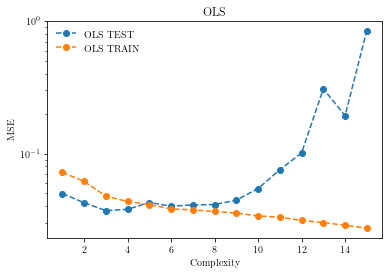

In [3]:
degrees = np.arange(1,max_degree+1)

plt.semilogy(degrees, mse_ols_test, "o--", label = "OLS TEST")
plt.semilogy(degrees, mse_ols_train, "o--", label = "OLS TRAIN")
plt.title("OLS")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.legend(frameon=False)
plt.savefig(FIGPATH + "OLS_MSE_Bootstrap_Hastie_211_N_{n}.pdf")

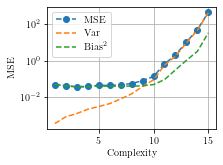

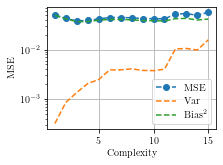

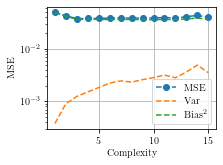

In [4]:
## BOOTSTRAP PLOTS
plt.figure(figsize=FIGURESIZE * 0.8)
plt.semilogy(degrees, ols_boot_mse,"o--",label="MSE")
plt.semilogy(degrees, ols_boot_variance,"--", label="Var")
plt.semilogy(degrees, ols_boot_bias,"--", label="Bias$^2$")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.tight_layout()
#plt.ylim([1e-4, 2e-1])
plt.legend()
plt.grid()
plt.savefig(FIGPATH+f"Franke_OLS_bootstrap_N_{n}.pdf")

plt.figure(figsize=FIGURESIZE * 0.8)
plt.semilogy(degrees, ridge_best_lambda_boot_mse,"o--",label="MSE")
plt.semilogy(degrees, ridge_best_lambda_boot_variance,"--", label="Var")
plt.semilogy(degrees, ridge_best_lambda_boot_bias,"--", label="Bias$^2$")
plt.xlabel("Complexity")
plt.ylabel("MSE")
#plt.ylim([1e-4, 2e-1])
plt.tight_layout()
plt.legend()
plt.grid()
plt.savefig(FIGPATH+f"Franke_Ridge_bootstrap_N_{n}.pdf")

plt.figure(figsize=FIGURESIZE * 0.8)
plt.semilogy(degrees, lasso_best_lambda_boot_mse,"o--",label="MSE")
plt.semilogy(degrees, lasso_best_lambda_boot_variance,"--", label="Var")
plt.semilogy(degrees, lasso_best_lambda_boot_bias,"--", label="Bias$^2$")
plt.xlabel("Complexity")
plt.ylabel("MSE")
#plt.ylim([1e-4, 2e-1])
plt.legend()
plt.tight_layout()
plt.grid()
plt.savefig(FIGPATH+f"Franke_LASSO_bootstrap_N_{n}.pdf")

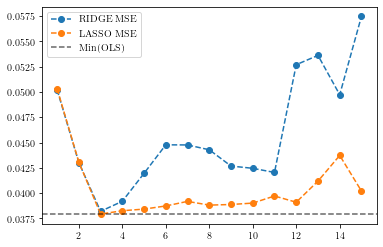

In [5]:
#plt.semilogy(degrees, ols_boot_mse,"o--",label="OLS MSE")
plt.plot(degrees, ridge_best_lambda_boot_mse,"o--",label="RIDGE MSE")
plt.plot(degrees, lasso_best_lambda_boot_mse,"o--",label="LASSO MSE")
plt.axhline(np.min(lasso_best_lambda_boot_mse), color="black", alpha=0.6, ls="--", label="Min(OLS)")

plt.legend()

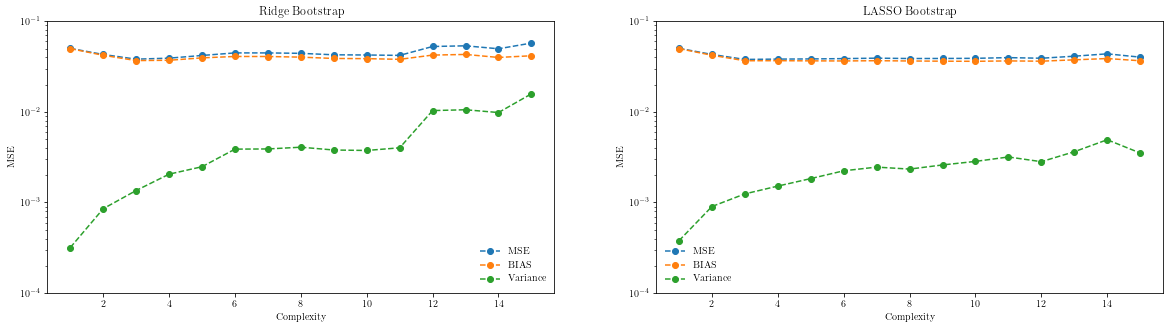

In [6]:
# Same bootstrap plots, but only better resolved LASSO & Ridge
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.semilogy(degrees, ridge_best_lambda_boot_mse,"o--",label="MSE")
plt.semilogy(degrees, ridge_best_lambda_boot_bias,"o--", label="BIAS")
plt.semilogy(degrees, ridge_best_lambda_boot_variance,"o--", label="Variance")
plt.title("Ridge Bootstrap")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.ylim([1e-4, 1e-1])
plt.legend(frameon=False)

plt.subplot(122)
plt.semilogy(degrees, lasso_best_lambda_boot_mse,"o--",label="MSE")
plt.semilogy(degrees, lasso_best_lambda_boot_bias,"o--", label="BIAS")
plt.semilogy(degrees, lasso_best_lambda_boot_variance,"o--", label="Variance")
plt.title("LASSO Bootstrap")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.ylim([1e-4, 1e-1])
plt.legend(frameon=False)
plt.show()

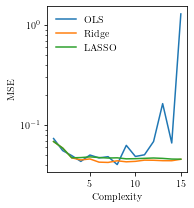

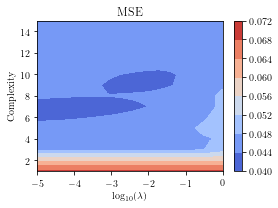

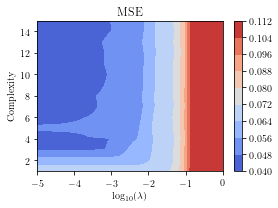

In [7]:
# CONTOUR PLOTS

plt.figure(figsize=FIGURESIZE*np.array([0.7, 1]))
#plt.axvline(degrees[np.argmin(ols_cv_mse)], ls="--", color="black", alpha=0.6)
plt.semilogy(degrees, ols_cv_mse, label="OLS")
plt.semilogy(degrees, best_ridge_mse, label="Ridge")
plt.semilogy(degrees, best_lasso_mse, label="LASSO")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.legend(loc="best", frameon=False)
plt.tight_layout()
plt.savefig(FIGPATH + f"OLS_CV_Franke_N_{n}.pdf")

# RIDGE
plt.figure(figsize=(4, 3) * np.array([1,1]))
X, Y = np.meshgrid(np.log10(lambdas), degrees)
plt.contourf(X, Y, ridge_lamb_deg_mse, cmap=cm.coolwarm)
plt.colorbar()
plt.xlabel("$\\log_{10}(\lambda)$")
plt.ylabel("Complexity")
plt.title("MSE")
plt.tight_layout()
plt.savefig(FIGPATH + f"RIDGE_CV_Franke_contour_N_{n}.pdf")

# LASSO
plt.figure(figsize=(4, 3))
X, Y = np.meshgrid(np.log10(lambdas), degrees)
plt.contourf(X, Y, lasso_lamb_deg_mse, cmap=cm.coolwarm)
plt.colorbar()
plt.xlabel("$\\log_{10}(\lambda)$")
plt.ylabel("Complexity")
plt.title("MSE")
plt.tight_layout()
plt.savefig(FIGPATH + f"LASSO_CV_Franke_contour_N_{n}.pdf")

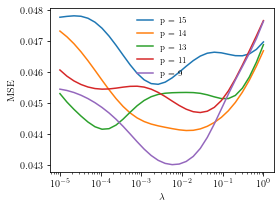

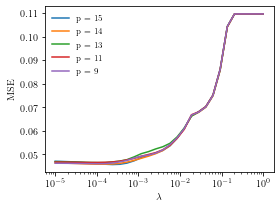

In [8]:
plt.figure(figsize=FIGURESIZE)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 1],
    label="p = {}".format(max_degree),
)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 2],
    label="p = {}".format(max_degree - 1),
)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 3],
    label="p = {}".format(max_degree - 2),
)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 5],
    label="p = {}".format(max_degree - 4),
)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 7],
    label="p = {}".format(max_degree - 6),
)
plt.xlabel("$\\lambda$")
plt.ylabel("MSE")
plt.tight_layout()
plt.legend(frameon=False, fontsize="small", loc='best')
plt.savefig(FIGPATH+f"RIDGE_best_lambda_FRANKE_N_{n}.pdf")

# For a copule of degrees, plot cv mse vs lambda for lasso, will break program if max_degree < 8.

plt.figure(figsize=FIGURESIZE)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 1],
    label="p = {}".format(max_degree),
)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 2],
    label="p = {}".format(max_degree - 1),
)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 3],
    label="p = {}".format(max_degree - 2),
)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 5],
    label="p = {}".format(max_degree - 4),
)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 7],
    label="p = {}".format(max_degree - 6),
)

plt.xlabel("$\\lambda$")
plt.ylabel("MSE")
plt.tight_layout()
plt.legend(frameon=False, fontsize="small", loc='best')
plt.savefig(FIGPATH+f"LASSO_best_lambda_FRANKE_N_{n}.pdf")

In [9]:
print(best_ridge_lambda)
print(best_lasso_lambda)

[1.00000000e+00 1.00000000e+00 2.80721620e-02 1.74332882e-03
 5.29831691e-04 1.00000000e-05 7.27895384e-05 5.29831691e-04
 5.73615251e-03 1.26896100e-02 2.80721620e-02 5.29831691e-04
 1.08263673e-04 1.26896100e-02 2.59294380e-03]
[5.29831691e-04 1.17210230e-03 1.00000000e-05 1.00000000e-05
 1.00000000e-05 1.00000000e-05 4.89390092e-05 1.61026203e-04
 1.08263673e-04 1.08263673e-04 7.27895384e-05 1.61026203e-04
 1.08263673e-04 1.08263673e-04 2.39502662e-04]


In [10]:
degree=5 # See how the best hyperparameters from CV-MSE above actually perform.
ridge_lambda=1e-2 # Ditto
lasso_lambda=1e-4 # Ditto
plot_grid_size=2000

np.random.seed(SEEDVAL)
x = np.random.uniform(0, 1, n)
y = np.random.uniform(0, 1, n)
z = FrankeFunction(x, y)
# Adding standard normal noise:
z = z + noise_scale * np.random.normal(0, 1, len(z))
#   Centering the response
z_intercept = np.mean(z)
z = z - z_intercept
# Scaling
X = linear_regression.design_matrix_2D(x, y, degree)
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled = X_scaled[:,1:]

# Setting up plotting grid
x_plot = np.linspace(0, 1, plot_grid_size)
y_plot = np.linspace(0, 1, plot_grid_size)
x_plot_mesh, y_plot_mesh = np.meshgrid(x_plot, y_plot)
x_plot_mesh_flat, y_plot_mesh_flat = x_plot_mesh.flatten(), y_plot_mesh.flatten()

X_plot_design = linear_regression.design_matrix_2D(x_plot_mesh_flat, y_plot_mesh_flat, degree)
X_plot_design_scaled = scaler.transform(X_plot_design)
X_plot_design_scaled = X_plot_design_scaled[:,1:]

z_plot_franke = FrankeFunction(x_plot_mesh, y_plot_mesh)

# OLS
betas = linear_regression.OLS_SVD_2D(X_scaled, z)
z_predict_flat_ols = (X_plot_design_scaled @ betas) + z_intercept
z_predict_ols = z_predict_flat_ols.reshape(plot_grid_size, -1)

# Ridge

betas_ridge = linear_regression.Ridge_2D(X_scaled, z, ridge_lambda)
z_predict_flat_ridge = (X_plot_design_scaled @ betas_ridge) + z_intercept
z_predict_ridge = z_predict_flat_ridge.reshape(plot_grid_size, -1)
# Lasso

clf_Lasso = skl.Lasso(alpha=lasso_lambda, fit_intercept=False, max_iter=10000).fit(X_scaled, z)
z_predict_flat_lasso = clf_Lasso.predict(X_plot_design_scaled) + z_intercept
z_predict_lasso = z_predict_flat_lasso.reshape(plot_grid_size, -1)


/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5918848763502069, tolerance: 0.005478510025237233
  model = cd_fast.enet_coordinate_descent(


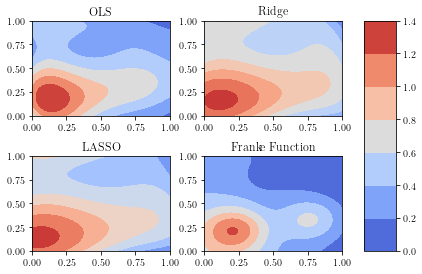

In [11]:
plt.subplot(221)
plt.contourf(x_plot_mesh, y_plot_mesh, z_predict_ols, cmap=cm.coolwarm)
plt.title("OLS")
plt.tight_layout()

plt.subplot(222)
plt.contourf(x_plot_mesh, y_plot_mesh, z_predict_ridge, cmap=cm.coolwarm)
plt.title("Ridge")
plt.tight_layout()

plt.subplot(223)
plt.contourf(x_plot_mesh, y_plot_mesh, z_predict_lasso, cmap=cm.coolwarm)
plt.title("LASSO")
plt.tight_layout()

plt.subplot(224)
plt.contourf(x_plot_mesh, y_plot_mesh, z_plot_franke, cmap=cm.coolwarm)
plt.title("Franke Function")
plt.tight_layout()


plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)

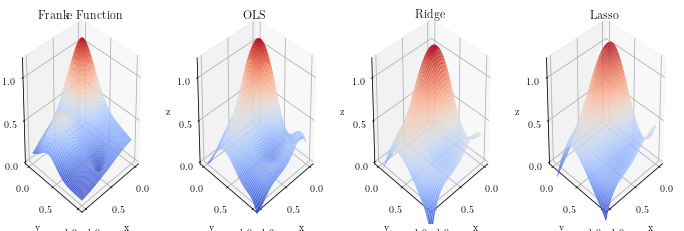

In [12]:
fig = plt.figure(figsize=(3 * 4,4))

# Plot the analytic curve
ax = fig.add_subplot(1, 4, 1, projection="3d")
ax.set_title("Franke Function")
ax.view_init(azim=45)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_zlim([0, 1.2])
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_plot_franke, cmap=cm.coolwarm)

# Plot the OLS prediction
ax = fig.add_subplot(1, 4, 2, projection="3d")
ax.set_title("OLS")
ax.view_init(azim=45)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_zlim([0, 1.2])

surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_predict_ols, cmap=cm.coolwarm)
# Plot the Ridge
ax = fig.add_subplot(1, 4, 3, projection="3d")
ax.set_title("Ridge")
ax.view_init(azim=45)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_zlim([0, 1.2])
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_predict_ridge, cmap=cm.coolwarm)
# Plot the Lasso
ax = fig.add_subplot(1, 4, 4, projection="3d")
ax.set_title("Lasso")
ax.view_init(azim=45)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_zlim([0, 1.2])
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_predict_lasso, cmap=cm.coolwarm)
